In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pygenomeviz import GenomeViz
import seaborn as sns
import requests
import json
import logging
import numpy as np
from Bio import Entrez

Entrez.email = "dzhumaniiazova.irina@gmail.com"

# Работаем со структурой гена

In [2]:
def get_transcripts_names(gene: str, info_transcripts = 'n', return_transcript = 'only canonical'):
    server = "https://rest.ensembl.org"
    search_canonical = "/lookup/symbol/homo_sapiens/" + gene + "?expand=1"

    r = requests.get(server+search_canonical, headers={ "Content-Type" : "application/json"})
    res = json.loads(r.content)
    
    try:
        canonical = res['canonical_transcript'].split('.')[0]
    except:
        canonical = res['canonical_transcript']

    non_canonical = []
    
    for i in range(len(res['Transcript'])):
        if res['Transcript'][i]['id']!=canonical:
            non_canonical.append((res['Transcript'][i]['id'], len(res['Transcript'][i]['Exon'])))
    
    if info_transcripts == 'y':
        additional_info = f'Canonical transcript (from NCBI database) for {gene} is {canonical}, however where are few other transcripts - {non_canonical}.\n \nThe number is the number of exons\n \nIf you want to get information about particular transcript, please, specify the "transcript_name" in the SHOW_EXON_STRUCTURE function. \nThe "transcript_name" should be a string'
        print (additional_info)
    
    if return_transcript == 'only canonical':
        return canonical
    else:
        return (canonical, non_canonical)

In [3]:
def get_gene_info(gene: str, transcript = 'canonical'):
    
    server = "https://rest.ensembl.org"
    if transcript == 'canonical':
        transcript_ = get_transcripts_names(gene)
        search_for_exons = "/lookup/id/" + transcript_+ "?expand=1"
    else:
        search_for_exons = "/lookup/id/" + transcript+ "?expand=1"
        
    r = requests.get(server+search_for_exons, headers={ "Content-Type" : "application/json"})
    res = json.loads(r.content)
    
    final = pd.DataFrame(res['Exon'])
    
    return final

In [4]:
def show_exon_structure(gene: str, 
                        give_df = 'n',
                        save_fig = 'n', 
                        transcript_name = 'canonical'):
    '''
    This function return you the picture of exons for different gene transcripts. By default, it is the canonical transcript
        from NCBI database. If you want to get additional info about other transcripts call the "get_transcripts_names" function
        with "info_transcripts = 'y'"" param and choose one.
    If you know the particular transcript name, please, specify "transcript_name" param by giving a string of the transcript name
    '''
    
    df= get_gene_info(gene, transcript = transcript_name)
    
    if transcript_name == 'canonical':
        transcript_name = get_transcripts_names(gene)
    
    df['len'] = df['end']-df['start']
    
    
    df.loc[0,'new_start'] = 0
    df.loc[0, 'new_end'] = df.loc[0, 'len']

    step = 50

    for i in range (1,len(df)):
        df.loc[i, 'new_start'] = step + df.loc[i-1, 'new_end']
        df.loc[i, 'new_end'] = df.loc[i, 'new_start'] + df.loc[i, 'len']
        
    exon_list=[]

    for i in range (len(df)):
        exon_start = df.loc[i, 'new_start']
        exon_end = df.loc[i, 'new_end']
        exon = (exon_start, exon_end)

        exon_list.append(exon)

    gv = GenomeViz()
    
    if df.loc[0, 'strand'] ==1:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))]
        df['exon_n'] = [i+1 for i in range(len(exon_list))]
    else:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))][::-1]
        df['exon_n'] = [i+1 for i in range(len(exon_list))][::-1]
        
    track = gv.add_feature_track(name=f"{gene} exons \n{transcript_name}",
                                 size=df.loc[len(df)-1, 'new_end']+100,
                                 labelsize=15,
                                 linewidth=0)
    
    track.add_exon_feature(exon_list,
                           strand=df.loc[0, 'strand'],
                           facecolor="lightcyan",
                           linewidth=1,
                           labelrotation=0,
                           labelha="center",
                           exon_labels=exon_labels,
                           exon_label_kws={"y": 0, "va": "center", "color": "blue", 'fontsize': 10},
                           size_ratio = 1)
    
    if save_fig == 'y':
        gv.savefig(f"{gene}_first.png")
    
    if give_df == 'y':
        return df
    else:
        return gv.plotfig()

In [5]:
transcript = get_transcripts_names('RET', info_transcripts = 'y')

Canonical transcript (from NCBI database) for RET is ENST00000355710, however where are few other transcripts - [('ENST00000671844', 16), ('ENST00000672389', 14), ('ENST00000340058', 19), ('ENST00000498820', 5), ('ENST00000615310', 17), ('ENST00000638465', 2), ('ENST00000640619', 2), ('ENST00000683278', 2), ('ENST00000684216', 2), ('ENST00000683007', 16), ('ENST00000683872', 9)].
 
The number is the number of exons
 
If you want to get information about particular transcript, please, specify the "transcript_name" in the SHOW_EXON_STRUCTURE function. 
The "transcript_name" should be a string


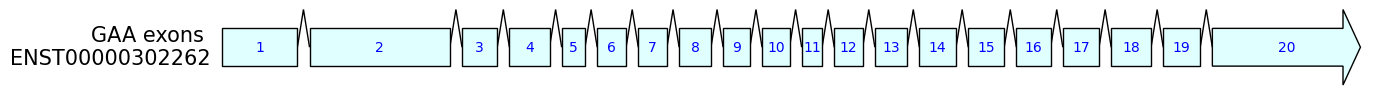

In [6]:
fig = show_exon_structure('GAA')

In [7]:
show_exon_structure('GAA', give_df = 'y')

,end,object_type,strand,assembly_name,id,version,species,seq_region_name,start,db_type,len,new_start,new_end,exon_n
0,80101890,Exon,1,GRCh38,ENSE00001374417,4,homo_sapiens,17,80101581,core,309,0.0,309.0,1
1,80105132,Exon,1,GRCh38,ENSE00001291648,2,homo_sapiens,17,80104555,core,577,359.0,936.0,2
2,80105894,Exon,1,GRCh38,ENSE00001164152,1,homo_sapiens,17,80105749,core,145,986.0,1131.0,3
3,80107722,Exon,1,GRCh38,ENSE00001164147,1,homo_sapiens,17,80107557,core,165,1181.0,1346.0,4
4,80107896,Exon,1,GRCh38,ENSE00001164143,1,homo_sapiens,17,80107800,core,96,1396.0,1492.0,5
5,80108409,Exon,1,GRCh38,ENSE00001164137,1,homo_sapiens,17,80108290,core,119,1542.0,1661.0,6
6,80108607,Exon,1,GRCh38,ENSE00001164130,1,homo_sapiens,17,80108489,core,118,1711.0,1829.0,7
7,80108828,Exon,1,GRCh38,ENSE00001164122,1,homo_sapiens,17,80108697,core,131,1879.0,2010.0,8
8,80110055,Exon,1,GRCh38,ENSE00001164117,1,homo_sapiens,17,80109945,core,110,2060.0,2170.0,9
9,80110840,Exon,1,GRCh38,ENSE00001164108,1,homo_sapiens,17,80110727,core,113,2220.0,2333.0,10


# Определяем положение мутаций в новой системе координат

In [8]:
def show_exon_and_mutations (gene: str,
                             df_mut,
                        give_df = 'n',
                        save_fig = 'n', 
                        transcript_name = 'canonical'):
    '''
    This function return you the picture of exons and given mutations for different gene transcripts. By default, it is the canonical transcript
        from NCBI database. If you want to get additional info about other transcripts call the "get_transcripts_names" function
        with "info_transcripts = 'y'"" param and choose one.
    If you know the particular transcript name, please, specify "transcript_name" param by giving a string of the transcript name
    '''
    
    df= get_gene_info(gene, transcript = transcript_name)
    
    if transcript_name == 'canonical':
        transcript_name = get_transcripts_names(gene)
    
    df['len'] = df['end']-df['start']
    
    
    df.loc[0,'new_start'] = 0
    df.loc[0, 'new_end'] = df.loc[0, 'len']

    step = 50

    for i in range (1,len(df)):
        df.loc[i, 'new_start'] = step + df.loc[i-1, 'new_end']
        df.loc[i, 'new_end'] = df.loc[i, 'new_start'] + df.loc[i, 'len']
        
    exon_list=[]

    for i in range (len(df)):
        exon_start = df.loc[i, 'new_start']
        exon_end = df.loc[i, 'new_end']
        exon = (exon_start, exon_end)

        exon_list.append(exon)

    gv = GenomeViz()
    
    if df.loc[0, 'strand'] ==1:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))]
        df['exon_n'] = [i+1 for i in range(len(exon_list))]
    else:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))][::-1]
        df['exon_n'] = [i+1 for i in range(len(exon_list))][::-1]
        
    df_mut['n']=''

    for i in range(len(df_mut)):
        for j in range(len(df)):
            if df.loc[j, 'start']<df_mut.loc[i, 'pos']<df.loc[j, 'end']:
                df_mut.loc[i,'n'] = j+1
                
    df_mut['pos_new'] = ''
    
    for i in range(len(df_mut)):
        if df_mut.loc[i, 'n'] != '':
            df_mut.loc[i,'pos_new'] = df.loc[df_mut.loc[i, 'n']-1, 'new_end'] - (df.loc[df_mut.loc[i, 'n']-1, 'end']-df_mut.loc[i, 'pos'])           

        
    track = gv.add_feature_track(name=f"{gene} exons \n{transcript_name}",
                                 size=df.loc[len(df)-1, 'new_end']+100,
                                 labelsize=15,
                                 linewidth=0)
    
    track.add_exon_feature(exon_list,
                           strand=df.loc[0, 'strand'],
                           facecolor="lightcyan",
                           linewidth=1,
                           labelrotation=0,
                           labelha="center",
                           exon_labels=exon_labels,
                           exon_label_kws={"y": 0, "va": "center", "color": "blue", 'fontsize': 10},
                           size_ratio = 1)
    
    for i in range(len(df_mut)):
        if df_mut.loc[i, 'n'] != '':
            track.add_feature(start=df_mut.loc[i,'pos_new']-5, end=df_mut.loc[i,'pos_new']+5, plotstyle="box", label=f"{df_mut.loc[i,'pos']}", labelrotation=90, labelsize=10, facecolor="black", labelha='center', size_ratio = 1)

    
    if save_fig == 'y':
        gv.savefig(f"{gene}_first.png")
    
    if give_df == 'y':
        return df
    else:
        return gv.plotfig()

# Работаем со структурой белков

In [11]:
def get_protein_info(gene: str,
                     to_return = 'filtered',
                     transcript_name = 'canonical'): #to_return = 'final' or 'all'
    
    if transcript_name == 'canonical':
        transcript_name = get_transcripts_names(gene)
        
        
    server_uni = "https://rest.uniprot.org"
    search_uniprot = "/uniprotkb/search?query="+transcript_name+"&format=json"
    
    try:
        r = requests.get(server_uni+search_uniprot, headers={ "Content-Type" : "application/json"})
        res = json.loads(r.content)
        
    except:
        return('No information about protein in UniProtKB')
    
    df = pd.DataFrame()
    
    #df.columns = ['type', 'start', 'end', 'description']
    for i in range(len(res['results'][0]['features'])):
        df.loc[i, 'type'] = res['results'][0]['features'][i]['type']
        df.loc[i, 'start'] = res['results'][0]['features'][i]['location']['start']['value']
        df.loc[i, 'end'] = res['results'][0]['features'][i]['location']['end']['value']
        df.loc[i, 'description'] = res['results'][0]['features'][i]['description']
        df.loc[i, 'len_p']= res['results'][0]['sequence']['length']
        
    for i in range (len(df)):
        if df.loc[i, 'type']=='Transmembrane':
            df.loc[i, 'description']='Transmembrane'
            
    if to_return in df['type'].unique():
        f = (df['type']=='Domain') | (df['type']=='Repeat') | (df['type']=='Intramembrane') | (df['type']==to_return)
        final=df[f]
        final = final.reset_index().drop('index', axis=1)
        return final
    
    elif to_return == 'filtered':
        f = (df['type']=='Domain') | (df['type']=='Repeat') | (df['type']=='Intramembrane')
        final=df[f]
        final = final.reset_index().drop('index', axis=1)
        return final
    
    else:
        return df

In [12]:
df = get_protein_info('GLB1', to_return = 'Active site')

In [13]:
df

,type,start,end,description,len_p
0,Active site,188.0,188.0,Proton donor,677.0
1,Active site,268.0,268.0,Nucleophile,677.0


# Аннотируем список позиций, которые нам передают

In [14]:
def mutation_annotation(mut: list, chr_n):
    
    api_root_url = 'https://api.ncbi.nlm.nih.gov/variation/v0/'
    
    df = pd.DataFrame()
    df['pos'] = mut
    df['chr'] = chr_n
    for i in range(len(df)):
        
        ask = f"{df.loc[i, 'chr']}[Chromosome] AND {df.loc[i, 'pos']}[Base position]"
        
        try:
            eShandle = Entrez.esearch(db="snp",
                                      term=ask, 
                                      usehistory="n",
                                      retmax=1)
            eSresult = Entrez.read(eShandle)
            rs = (eSresult['IdList'])[0]
            try:
                df.loc[i, 'rs']=rs
                url = api_root_url + 'beta/refsnp/' + str(rs)
                req = requests.get(url)
                res = json.loads(req.content)
                
                for j in range(len(res['primary_snapshot_data']['allele_annotations'][0]['assembly_annotation'][0]['genes'][0]['rnas'])):
    
                    try:
                        pos = res['primary_snapshot_data']['allele_annotations'][0]['assembly_annotation'][0]['genes'][0]['rnas'][j]['protein']['variant']['spdi']['position']
                    except:
                        continue
                        
                df.loc[i, 'protein_pos'] = pos
            except:
                df.loc[i, 'protein_pos'] = ''
                
        except:
            df.loc[i, 'rs']=''
            df.loc[i, 'protein_pos'] = ''
            
    return df

In [15]:
mutation_annotation(mut=[43104974,43105029,43105119,43105176,43105191,43106428,43106433], chr_n=10)

,pos,chr,rs,protein_pos
0,43104974,10,1837728413,215.0
1,43105029,10,,
2,43105119,10,,
3,43105176,10,1588866311,283
4,43105191,10,1837741195,288
5,43106428,10,1554817979,306
6,43106433,10,769894584,308


In [16]:
def get_protein_picture(gene, save_fig = 'n', give_df = 'n'):
    
    df_p=pd.DataFrame()
    
    try:
        df_p = get_protein_info(gene)
    except:
        return('No info about protein')
    
    gv = GenomeViz()
    
    track = gv.add_feature_track(name=f"{gene} protein",
                                 size= df_p.loc[0,'len_p']*3,
                                 labelsize=15,
                                 linewidth=90,
                                 linecolor='lightgrey')
    for i in range (len(df_p)):
        start = int(df_p.loc[i, 'start'])*3
        end = int(df_p.loc[i, 'end'])*3
        color='pink'
        label=df_p.loc[i, 'description']
        track.add_feature(start=start,
                              end=end,
                              plotstyle="bigbox",
                              strand=1,
                              linewidth=0.5,
                              facecolor=color,
                              size_ratio = 1,
                              label=label,
                              labelrotation=90,
                              labelha="center",
                              labelvpos="center")
        
    if save_fig == 'y':
        gv.savefig(f"{gene}_protein_structure.png")
    
    if give_df == 'y':
        return df_p
    else:
        return gv.plotfig()
    
    return gv.plotfig()

In [17]:
fig = get_protein_picture('RET', give_df = 'y')

In [20]:
def final_picture(gene, mut: list, chr_n, give_df = 'n', save_fig = 'n', transcript_name = 'canonical'):
    
    df= get_gene_info(gene, transcript = transcript_name)
    df_mut = mutation_annotation(mut = mut, chr_n = chr_n)
    df_mut_1 = pd.DataFrame(df_mut['pos'])
    
    track = get_protein_picture(gene)
    track = show_exon_and_mutations(gene, df_mut_1)

    pass

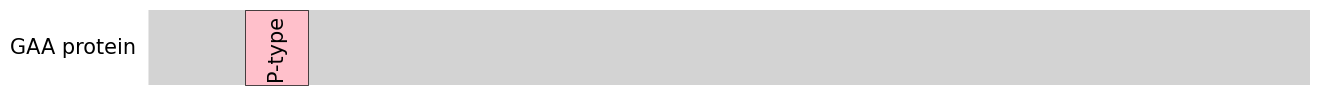

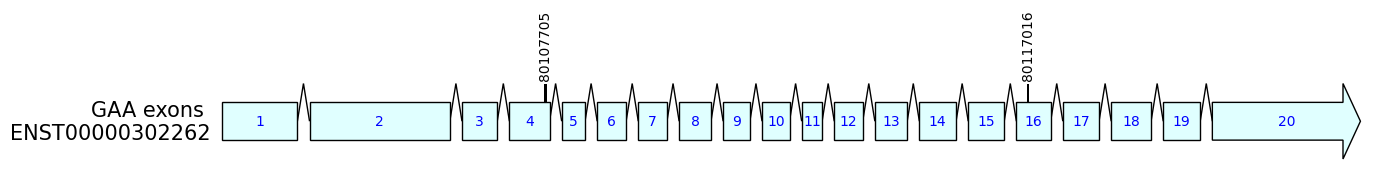

In [21]:
final_picture('GAA', mut = [80107705,80117016], chr_n=17)

In [34]:
def gene_protein_picture(gene,
                         mut: list,
                         chr_n,
                         transcript_name = 'canonical',
                         to_return = 'filtered',
                         get_lines=None,
                         height=2.0):
    
    df = get_gene_info(gene, transcript = transcript_name)
    
    if transcript_name == 'canonical':
        transcript_name = get_transcripts_names(gene)
    
    df['len'] = df['end']-df['start']
    
    
    df.loc[0,'new_start'] = 0
    df.loc[0, 'new_end'] = df.loc[0, 'len']

    step = 50

    for i in range (1,len(df)):
        df.loc[i, 'new_start'] = step + df.loc[i-1, 'new_end']
        df.loc[i, 'new_end'] = df.loc[i, 'new_start'] + df.loc[i, 'len']
        
    exon_list=[]

    for i in range (len(df)):
        exon_start = df.loc[i, 'new_start']
        exon_end = df.loc[i, 'new_end']
        exon = (exon_start, exon_end)

        exon_list.append(exon)
        
    exon_labels = [f"{i+1}" for i in range(len(exon_list))]
    df['exon_n'] = [i+1 for i in range(len(exon_list))]
        
    df_mut = mutation_annotation(mut = mut, chr_n = chr_n)
    
    df_mut['n']=''

    for i in range(len(df_mut)):
        for j in range(len(df)):
            if (df.loc[j, 'start']<df_mut.loc[i, 'pos']<df.loc[j, 'end']) or (df.loc[j, 'start']<df_mut.loc[i, 'pos']+50<df.loc[j, 'end']):
                df_mut.loc[i,'n'] = j+1
            
                
    df_mut['pos_new'] = ''
    
    for i in range(len(df_mut)):
        if df_mut.loc[i, 'n'] != '':
            df_mut.loc[i,'pos_new'] = df_mut.loc[i, 'pos']-df.loc[df_mut.loc[i, 'n']-1, 'start'] + df.loc[df_mut.loc[i, 'n']-1, 'new_start']          

    
    fig_track_height = height
    
    gv = GenomeViz(fig_track_height=height,
    feature_track_ratio=0.5,
    link_track_ratio=0.4,
    tick_track_ratio=0.5,
    align_type="center")
    
    df_p=pd.DataFrame()
    
    try:
        df_p = get_protein_info(gene, to_return=to_return)
    except:
        return('No info about protein')
    
    df_p.reset_index(inplace=True)
    
    coef = (df.loc[len(df)-1, 'new_end'])/(df_p.loc[0,'len_p']*3)
    
    track2 = gv.add_feature_track(name=f"{gene} protein",
                                 size= df_p.loc[0,'len_p']*coef,
                                 labelsize=15,
                                 linewidth=height*100,
                                 linecolor='lightgrey')
    
    for i in range (len(df_p)):
        start = int(df_p.loc[i, 'start'])*coef
        end = int(df_p.loc[i, 'end'])*coef
        color='pink'
        label=df_p.loc[i, 'description']
        track2.add_feature(start=start,
                              end=end,
                              plotstyle="bigbox",
                              strand=df.loc[0, 'strand'],
                              linewidth=0.5,
                              facecolor=color,
                              size_ratio = 1,
                              label=label,
                              labelrotation=90,
                              labelha="center",
                              labelvpos="center")
    
    track = gv.add_feature_track(name=f"{gene} exons \n{transcript_name}",
                                 size=df.loc[len(df)-1, 'new_end'],
                                 labelsize=15,
                                 linewidth=0)
    
    track.add_exon_feature(exon_list,
                           strand=df.loc[0, 'strand'],
                           facecolor="lightcyan",
                           linewidth=1,
                           labelrotation=0,
                           labelha="center",
                           exon_labels=exon_labels,
                           exon_label_kws={"y": 0, "va": "center", "color": "blue", 'fontsize': 10},
                           size_ratio = 1)

    for i in range (len(mut)):
        name = (f"rs{df_mut.loc[i,'rs']}" if df_mut.loc[i,'rs']!='' else f"{df_mut.loc[i,'pos']}")
        track.add_feature(start=int(df_mut.loc[i,'pos_new'])-5,
                            end=int(df_mut.loc[i,'pos_new'])+5,
                            plotstyle="box",
                            label=name,
                            labelrotation=90,
                            labelsize=10,
                            facecolor="black",
                            labelha='center',
                            size_ratio = 1)
    
    df_p['n_start'] = 1
    df_p['n_end'] = 1

    for i in range(len(df_p)):
        for j in range(len(df)):
            if (df.loc[j, 'new_start']<df_p.loc[i, 'start']*coef<df.loc[j, 'new_end']) or (df.loc[j, 'new_start']<(df_p.loc[i, 'start']*coef+50)<df.loc[j, 'new_end']):
                df_p.loc[i,'n_start'] = j+1

    for i in range(len(df_p)):
        for j in range(len(df)):
            if (df.loc[j, 'new_start']<df_p.loc[i, 'end']*coef<df.loc[j, 'new_end']) or (df.loc[j, 'new_start']<df_p.loc[i, 'end']*coef+50<df.loc[j, 'new_end']):
                    df_p.loc[i,'n_end'] = j+1

    df_p['gene_start'] = [(df_p.loc[x,'start']/df_p.loc[x,'len_p'])*(df.loc[len(df)-1, 'new_end']) for x in list(df_p.index)]
    
    df_p['gene_end'] = [df_p.loc[x, 'gene_start']+((df_p.loc[x,'end']-df_p.loc[x,'start'])/df_p.loc[x,'len_p'])*(df.loc[len(df)-1, 'new_end']) for x in list(df_p.index)]
    
    for i in range(len(df_p)):
        gv.add_link((f"{gene} protein", int(df_p.loc[i, 'start']*coef), int(df_p.loc[i, 'end']*coef)),
                    (f"{gene} exons \n{transcript_name}", int(df_p.loc[i, 'gene_start']), int(df_p.loc[i, 'gene_end'])),
                    curve=True,
                    normal_color='pink',
                    alpha = 0.4)
    
    if get_lines==None:
        for i in range(len(df_mut)):
            try:
                gv.add_link((f"{gene} protein", int(df_mut.loc[i,'protein_pos'])*coef-5, int(df_mut.loc[i,'protein_pos'])*coef+5),
                            (f"{gene} exons \n{transcript_name}", int(df_mut.loc[i,'pos_new'])-5, int(df_mut.loc[i,'pos_new'])+5),
                            curve=True,
                            normal_color='black',
                            alpha = 0.4)
            except:
                print('no protein position')
    
    return gv.plotfig()

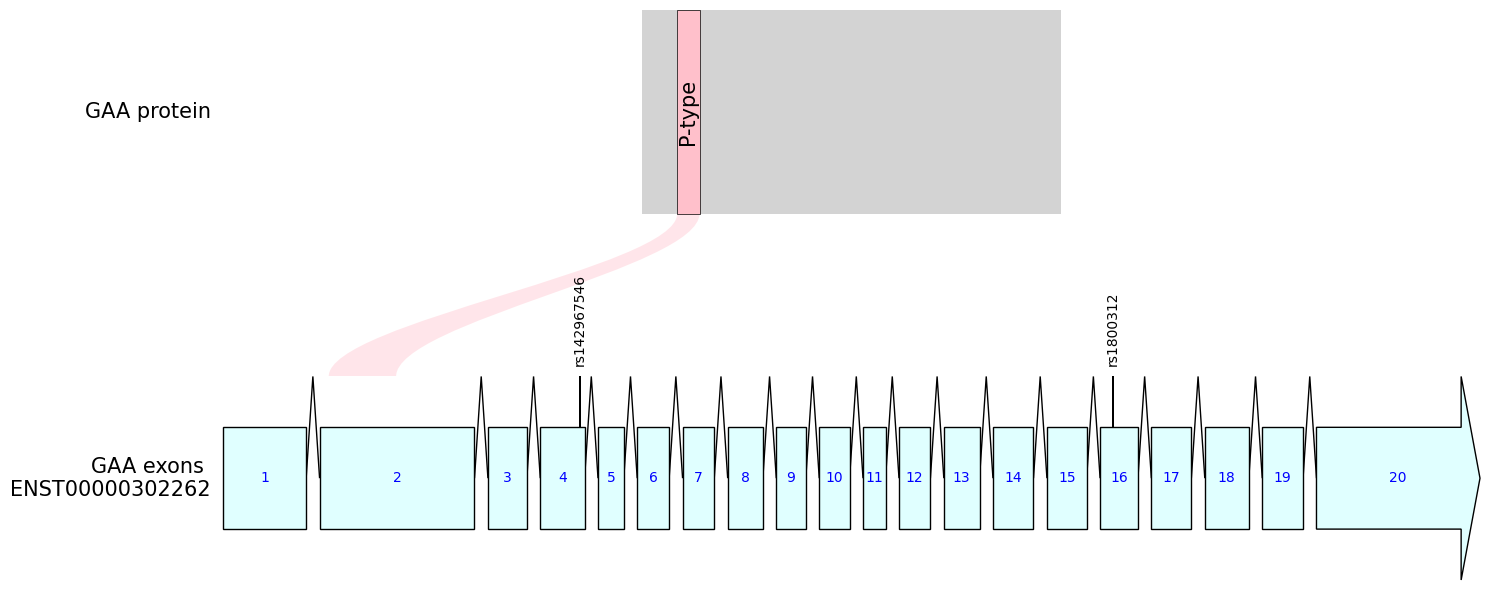

In [35]:
fig = gene_protein_picture('GAA', mut=[80107705, 80117016], chr_n=17, height=2.0, get_lines='no')

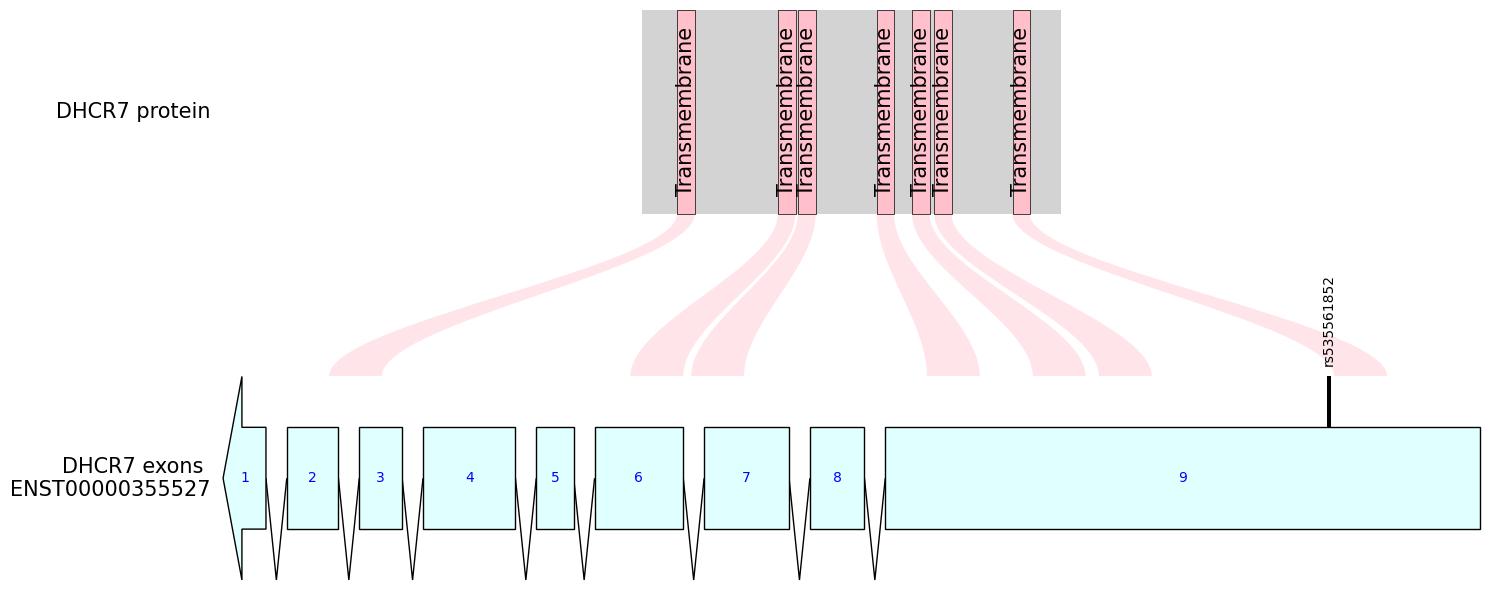

In [36]:
fig = gene_protein_picture('DHCR7',
                           mut=[71435476],
                           chr_n=11,
                           to_return='Transmembrane',
                           get_lines='No')

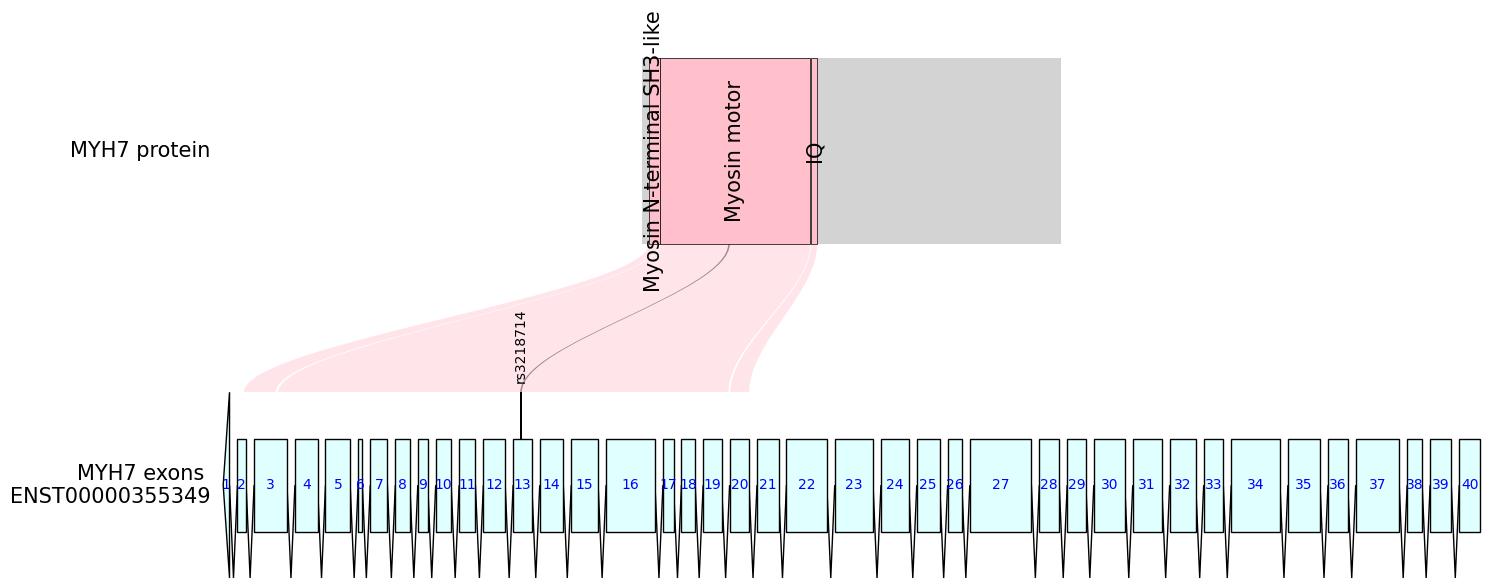

In [37]:
fig = gene_protein_picture('MYH7',
                           mut=[23429279],
                           chr_n=14,
                           #to_return='Transmembrane',
                           height=2.0)

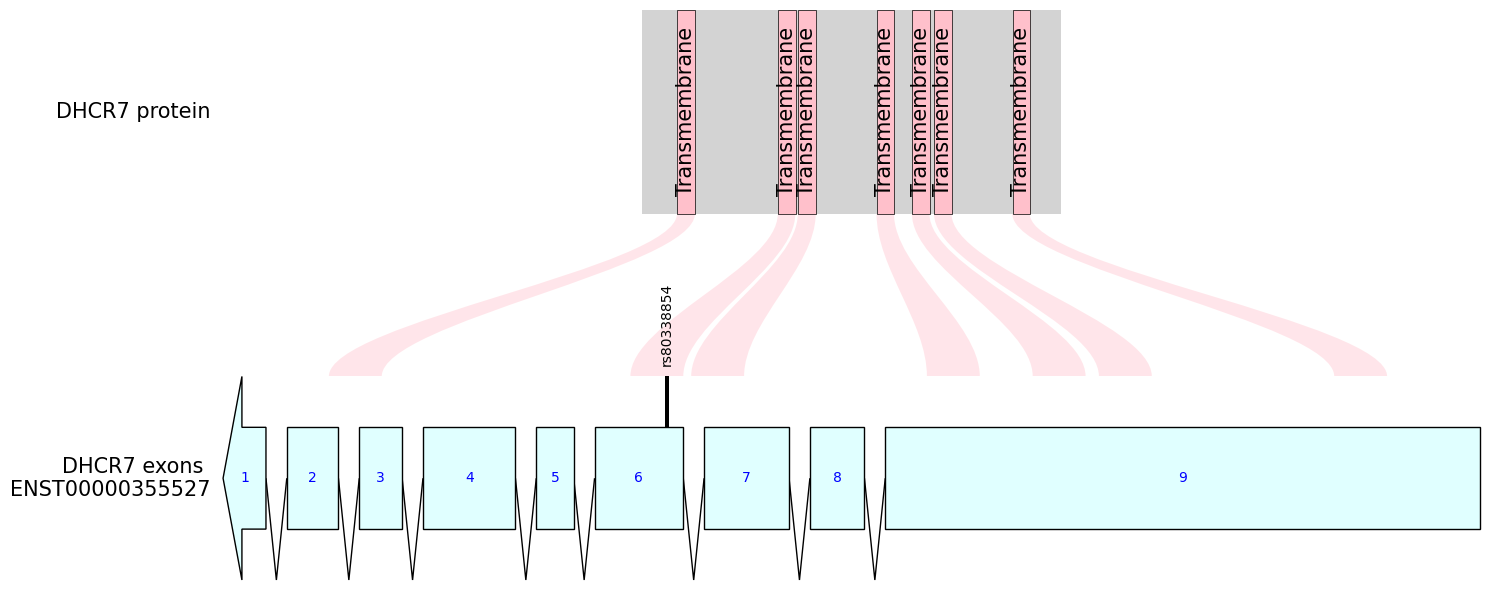

In [38]:
fig = gene_protein_picture('DHCR7',
                           mut=[71441401],
                           chr_n=11,
                           to_return='Transmembrane',
                           height=2.0,
                           get_lines='no')